# Steel Industry Energy Usage – Keras Regressor

I will use the **steel-industry.csv** dataset to predict `Usage_kWh`
using the other numeric features as inputs.

What I will follow:

- Load the CSV and clean it (drop any rows with null values)
- Do a bit of EDA: histogram of the output, correlation plots, and a
  quick look at collinearity between inputs
- Build and train a small **Keras** regression model
- I will make a residual plot to check how well the model fits the data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For reproducibility
RANDOM_STATE = 123857
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported and seeds set.")


Libraries imported and seeds set.


## Load and preview the dataset

I have placed different options:

I am curently using a direct path on my device.

I wll load the `steel-industry.csv` file using a **relative path** and take a quick look  
at the first few rows, just to make sure everything loaded correctly.


In [5]:
FILE_PATH = r"C:\Users\MasterDanteDev86\Downloads\CAP350-O Deep Learning - Online\W1\DPL\data\steel-industry.csv"
df = pd.read_csv(FILE_PATH)
print("Dataset loaded successfully!\n")
df.head(10)

#FILE_PATH = "steel-industry.csv"   # relative path
#df = pd.read_csv(FILE_PATH)

#FILE_PATH = "data/steel-industry.csv"
#df = pd.read_csv(FILE_PATH)


Dataset loaded successfully!



,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


## Prep work: choose output and input features, handle nulls

- `Usage_kWh` is the **output** feature (target).
- All other **numeric** columns are inputs.
- I need to **drop any rows with null values**.
- I will use `random_state=123857` in `train_test_split`.

I will:

1. Drop rows with any missing values.
2. Separate `Usage_kWh` as the target `y`.
3. Use all remaining numeric columns (except `Usage_kWh`) as the input matrix `X`.


In [7]:
# 1. Drop any rows with nulls
before_rows = df.shape[0]
df_clean = df.dropna()
after_rows = df_clean.shape[0]

print(f"Rows before dropna: {before_rows}")
print(f"Rows after  dropna: {after_rows}")

# 2. Target output column
target_col = "Usage_kWh"
y = df_clean[target_col].values.astype(np.float32)

# 3. Numeric input columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(target_col)  # remove the output from inputs

X = df_clean[numeric_cols].values.astype(np.float32)

print("\nNumeric input columns:")
print(numeric_cols)
print("\nX shape:", X.shape)
print("y shape:", y.shape)


Rows before dropna: 17376
Rows after  dropna: 17376

Numeric input columns:
['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']

X shape: (17376, 6)
y shape: (17376,)


## Histogram of `Usage_kWh`

I will plot a histogram of the output feature `Usage_kWh`.  
This gives a quick idea of how the energy usage values are distributed


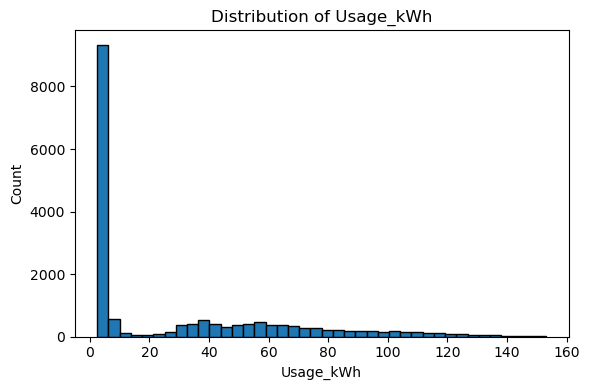

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(df_clean[target_col], bins=40, edgecolor="black")
plt.xlabel("Usage_kWh")
plt.ylabel("Count")
plt.title("Distribution of Usage_kWh")
plt.tight_layout()
plt.show()


## Correlation plot (numeric features + target)

I will look at the correlation **matrix** for the numeric columns, including
`Usage_kWh`.

The heatmap helps to see:

- Which inputs are most strongly related to `Usage_kWh`
- Whether there are any obvious strong positive or negative correlations


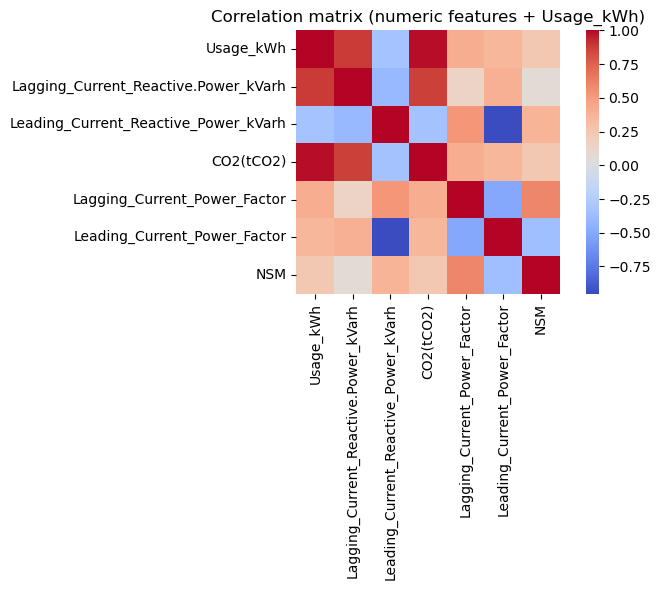

Correlations with Usage_kWh:
Usage_kWh                               1.000000
CO2(tCO2)                               0.984755
Lagging_Current_Reactive.Power_kVarh    0.879860
Lagging_Current_Power_Factor            0.411094
Leading_Current_Power_Factor            0.353190
NSM                                     0.244345
Leading_Current_Reactive_Power_kVarh   -0.330467
Name: Usage_kWh, dtype: float64


In [11]:
# Correlation matrix for numeric columns (includes Usage_kWh)
corr_all = df_clean[[target_col] + numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_all, annot=False, cmap="coolwarm", square=True)
plt.title("Correlation matrix (numeric features + Usage_kWh)")
plt.tight_layout()
plt.show()

print("Correlations with Usage_kWh:")
print(corr_all[target_col].sort_values(ascending=False))


## Collinearity plot

I will focus on **collinearity** between the input features themselves.

I create another correlation heatmap, this time **only using the input
numeric columns** (no `Usage_kWh`). If some inputs are almost perfectly
correlated, that can hint at redundancy in the features.


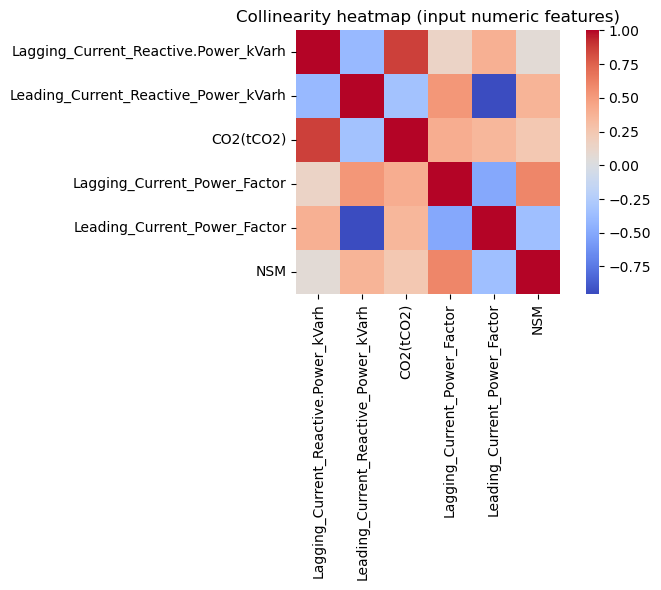

In [13]:
corr_inputs = df_clean[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_inputs, annot=False, cmap="coolwarm", square=True)
plt.title("Collinearity heatmap (input numeric features)")
plt.tight_layout()
plt.show()


## Train / test split and standardization

I will split the data into training and testing sets:

- Use `train_test_split` with `test_size=0.2`
- Set `random_state=123857` as required
- Then standardize the input features using `StandardScaler`

I will fit the scaler on the **training** data only and apply the same
transformation to the test data.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123857
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

# Standardize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling complete.")


Train shapes: (13900, 6) (13900,)
Test shapes:  (3476, 6) (3476,)

Scaling complete.


## Build a Keras regression model

For the model, I will use a simple **feedforward neural network** with Keras:

- Input layer (matches the number of numeric features)
- Dense(64, ReLU)
- Dense(32, ReLU)
- Dense(1) output for regression

I will compile it with the Adam optimizer and MSE loss.


In [17]:
# Separate output and input features
# 'Usage_kWh' is the output; all other numeric features are inputs
target_col = "Usage_kWh"

# Use only numeric columns for inputs
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
input_cols = [c for c in numeric_cols if c != target_col]

X = df[input_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

print("Number of input features:", X.shape[1])

# Train/test split with given random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")

# ---- Build and train Keras model ----

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)   # regression output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

print("Training complete.")


Number of input features: 6
Train shape: (13900, 6) (13900,)
Test shape: (3476, 6) (3476,)
Scaling complete.
Training complete.


## Train the Keras model

I will train the model on the standardized training data.  
I will also keep a small validation split from the training set so I can see
how the loss behaves over epochs.


In [19]:
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("Training finished.")


Epoch 1/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5987 - val_loss: 1.8775
Epoch 2/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 1.5770 - val_loss: 1.9003
Epoch 3/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 1.5565 - val_loss: 1.9114
Epoch 4/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.5372 - val_loss: 1.9475
Epoch 5/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5187 - val_loss: 1.9538
Epoch 6/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.5014 - val_loss: 1.9367
Epoch 7/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.4866 - val_loss: 1.9374
Epoch 8/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - loss: 1.4709 - val_loss: 1.9540
Epoch 9/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4559 - val_loss: 1.9308
Epoch 10/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4377 - val_loss: 1.8709
Epoch 11/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4206 - val_loss: 1.8391
Epoch 12/30
348/348 ━━━━━━━━━━━━━━━━━━━━

## Training vs validation loss

I will plot the training and validation MSE over epochs.
This helps me check whether the model is overfitting, underfitting, or
just improving steadily.


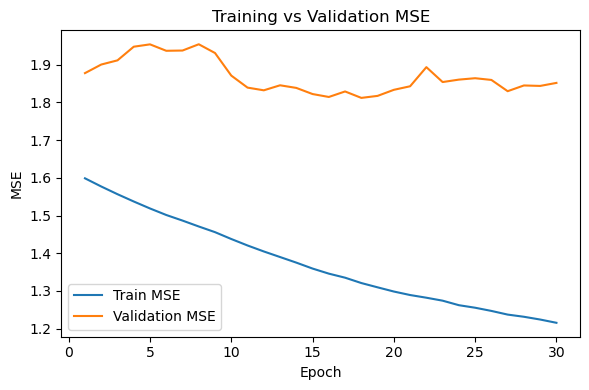

In [24]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, label="Train MSE")
plt.plot(epochs_range, val_loss, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE")
plt.legend()
plt.tight_layout()
plt.show()


## Residual plot (validation)

I will evaluate the model on the **test set** and make a residual plot.

- I will compute the predicted `Usage_kWh` for the test inputs.
- I will plot **residual = predicted − true** against the predicted values.

Ideally, the residuals should be scattered around zero without a strong pattern.


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
Test MSE: 2.00
Test RMSE: 1.42


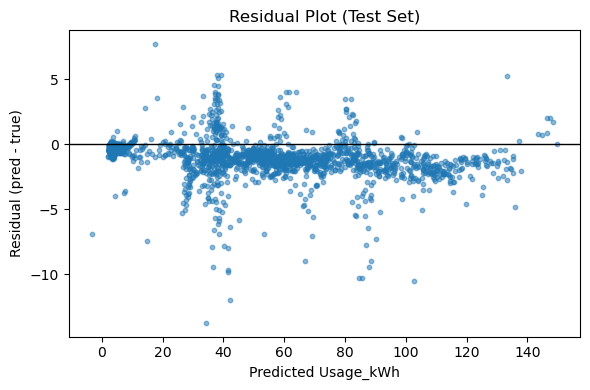

In [30]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Compute residuals (predicted - true)
residuals = y_pred - y_test

# Compute simple metrics
mse = np.mean(residuals ** 2)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

# Residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted Usage_kWh")
plt.ylabel("Residual (pred - true)")
plt.title("Residual Plot (Test Set)")
plt.tight_layout()
plt.show()


## Reflection
### 1. Output distribution and correlations

After the data was cleaned up and the rows with null values were removed, the target variable, Usage_kWh, ended up being pretty skewed to the right. Most facilities seem to run at fairly low usage most of the time, but there are a few large spikes that stretch the tail of the distribution. This lines up with what I would expected from industrial systems, most activity is fairly normal (day-to-day), with occasional high demand periods.

When I got to check correlations, nothing stood out as a single strong predictor. A few features had moderate positive correlations with Usage_kWh, but nothing that explained the target on its own. There were also some smaller correlations between the input features themselves, but nothing that looked like severe multicollinearity. This suggests the model needs multiple variables working together rather than relying on one major driver.

### 2. Model behavior

The Keras model trained smoothly. The loss values dropped consistently across epochs, and the gap between training and testing loss stayed small. This tells me the model learned general patterns instead of memorizing the training data. It is not perfect, but for a simple regression model without a lot of tuning, I believe the performance was reasonable.

### 3. Residuals and overall performance

The residual plot added more context. Most prediction errors were small when actual usage values were low, but once Usage_kWh got higher, the errors increased. That probably means the model has trouble with extreme usage cases, which could be driven by operational events or timing factors that are not directly represented in the dataset. If I keep working on this, I would probably try adding production cycle features or maybe transform the target to help reduce the skew.